# <center> Housing Price Prediction </center>

# Overview:


- #### **The Data**
    - This datasets contains features for ~ 23k houses in Kings County in Seattle, Washington
    - These features include sale price, number of bed/bathrooms, living/lot square footage, condition/grade, age, and location
- #### **The Goal**
    - The end goal is to predict the sale price of a home given the other features using Linear Regression
    - The focus of this project will not be on advanced modelling techniques nor hyperparameter tuning, but instead on....
        - Handling NaNs, Duplicates, Dtypes
        - Data Cleaning
        - Exploratory Data Analysis
        - Feature Engineering
        - Understanding the output of the linear regression model for decision making

# Notebook Outline

- #### **Part 1: Cleaning and EDA**
    - Handle duplicates, NaN's, dtypes, and minimal feature engineering
    - Each feature's distribution is viewed as its relationship with our dependent variable
- #### **Part 2: Feature Engineering and EDA:**
    - Create new features from the original features
    - View distributions and relationship with dependent variable
- #### **Part 3: Modelling and Evaluation**
    - Determine which model was the most successful in prediction
    - Determine which methods were most impactful on model performance (feature engineering vs transforming etc)

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center><u> Part 1: Data Cleaning </u></center>

### Import Packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import branca.colormap as cm
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.simplefilter(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Define custom functions

In [2]:
def hist_box(data, xlabel = None, title = None, font_scale=2, figsize=(9,8), bins = None, x_lim = []):
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(data, ax=ax_box2)
    sns.distplot(data, ax=ax_hist2, bins=bins) if bins else sns.distplot(data, ax=ax_hist2)
    ax_hist2.ticklabel_format(useOffset=False, style='plain')
    if x_lim != []:
        ax_hist2.set_xlim(x_lim[0],x_lim[1])
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

### Import Data and Inspect

In [3]:
# Import .csv file into DataFrame
df = pd.read_csv(r'kc_house_data.csv')

# Rename columns and index for interpretability
new_names = {'id':'sale_id','date':'sale_date','price':'sale_price','view':'has_been_viewed','sqft_above':'sqft_no_basement',
             'sqft_living15':'sqft_living_15_nn','sqft_lot15':'sqft_lot_15_nn'}

df.rename(columns = new_names, inplace=True)
df.index.name = 'unique_id'

# View sample of DataFrame
display(df.shape)
df.sample(2)

(21597, 21)

,sale_id,sale_date,sale_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,has_been_viewed,condition,grade,sqft_no_basement,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living_15_nn,sqft_lot_15_nn
unique_id,,,,,,,,,,,,,,,,,,,,,
14729,3761100276,3/13/2015,588000.0000,4,2.2500,2510,19550,1.0000,0.0000,0.0000,4,9,1810,700.0,1977,0.0000,98034,47.7041,-122.2410,2450,19250
12204,6300000320,8/21/2014,359950.0000,2,1.0000,1240,7590,1.0000,0.0000,0.0000,4,7,1040,200.0,1939,NaN,98133,47.7061,-122.3400,1190,5692


# <center> ----------------------------------------------------------------------------------------------------------- </center>

# Duplicates and Missing Data

## Duplicates
- The `sale_id` column does have duplicates, but they appear to be unique sales for the same house

In [4]:
df['sale_id'].duplicated().value_counts()

False    21420
True       177
Name: sale_id, dtype: int64

In [5]:
df.duplicated().value_counts()

False    21597
dtype: int64

## Missing Data

In [6]:
df_nans = pd.DataFrame()
df_nans['Count'] = df.isna().sum()
df_nans['Percent'] = round(df.isna().mean()*100,1)
df_nans[df_nans['Count'] > 0]

,Count,Percent
waterfront,2376,11.0000
has_been_viewed,63,0.3000
yr_renovated,3842,17.8000


### The following columns are missing data
- **`waterfront`** : Missing 2376 values **(11%)**
    - This could be fixed by looking at a map view
    - On average ~ 0.05% of houses are waterfront, so that would mean hand picking only ~12 houses, the rest can be labeled 0
- **`has_been_viewed`** : Missing 63 values **(<1%)**
    - This is such a small subset its likely okay to just drop
- **`yr_renovated`** : Missing 3842 values **(17%)**
    - 96% of homes have not been renovated, so filling with 0 is likely appropriate
    - Might be a good idea testing model with it filled with 0 vs dropped
- **`sqft_basement`** : Has 454 value set to "?" **(2%)** and is the wrong dtype
    - Most houses have no basement, likely okay to fill with 0

#### Waterfront Map
- Plot houses missing `waterfront` data

In [7]:
# Get hand picked list
actually_waterfront = [3577000116,1568100920,2726049034,3761700053,825059178,7129303070,2579500110,1724069060,9201300020,573000685]

# Use list to fill with 1s, then fill the rest with 0s
df.loc[df['sale_id'].isin(actually_waterfront), 'waterfront'] = 1
df['waterfront'] = df['waterfront'].fillna(0)

In [8]:
# Fill with 0s
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [9]:
# Replace "?" with nan
df['sqft_basement'].replace("?", np.nan, inplace = True)

df['sqft_basement'] = df['sqft_basement'].astype(float)

# Drop NaNs
df = df.dropna()

# <center> ----------------------------------------------------------------------------------------------------------- </center>

# Data Cleaning & EDA

## 1) Sale Price: 
- Target/Dependent Variable
- Strong Positive Skew
- Likely need to transform for normality

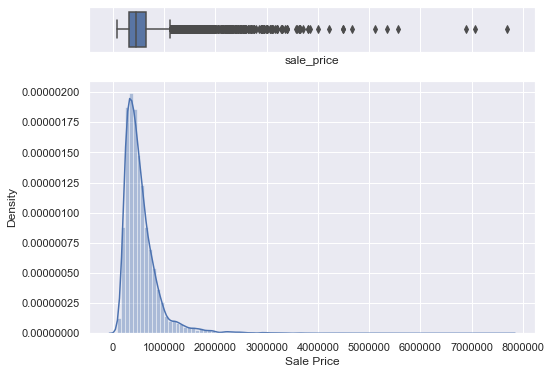

In [10]:
hist_box(df['sale_price'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price", 
        )

## 2) Sale Date: 
- Cast to proper data type
- Extract year/month

In [11]:
# Convert to dt
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Get month & year together
df['sale_date_monthly'] = df['sale_date'].dt.to_period('M')

# Get year
df['sale_year'] = df['sale_date'].dt.year

# Get month
df['sale_month'] = df['sale_date'].dt.month

- View stats by month

In [12]:
date_df = pd.DataFrame()
date_df['num_sales'] = df.groupby('sale_date_monthly')['sale_id'].count()
date_df['mean_sale_price'] = df.groupby('sale_date_monthly')['sale_price'].mean().astype(int)
date_df['n_days'] = df.groupby('sale_date_monthly')['sale_date'].nunique()
date_df

,num_sales,mean_sale_price,n_days
sale_date_monthly,,,
2014-05,1724,545803,30
2014-06,2126,558882,30
2014-07,2163,544584,31
2014-08,1894,536062,31
2014-09,1717,528538,30
2014-10,1831,539036,31
2014-11,1375,523796,29
2014-12,1442,525191,29
2015-01,947,526844,26


- There appears to be a positive linear relationship between the number of houses sold in a month and the mean sale price
    - There is one outlier (641), however this month has incomplete data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


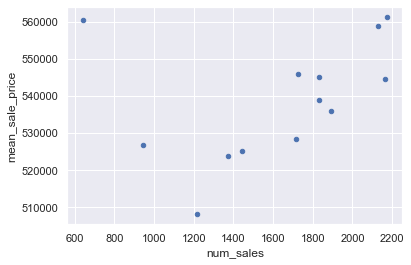

In [13]:
date_df.plot.scatter(x='num_sales',y='mean_sale_price');

- There appears to be a trend in sale price by month
    - Peak = summer
    - Trough = winter

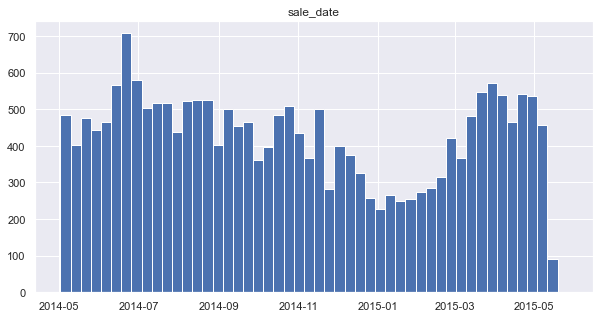

In [14]:
df.hist('sale_date', bins=50, figsize = (10,5));

- These are interesting relationships, it may be the case that:
    - The housing market has seasonality which drives up demand in the summer
    - This increased demand leads to higher sale prices
- This will be engineered as a feature in the next section!

## 3) Bedrooms: 
- One outlier with 30+ bedrooms (dropped)

In [15]:
df = df[df['bedrooms'] < 15]

- Most homes have between 2 and 5 bedrooms

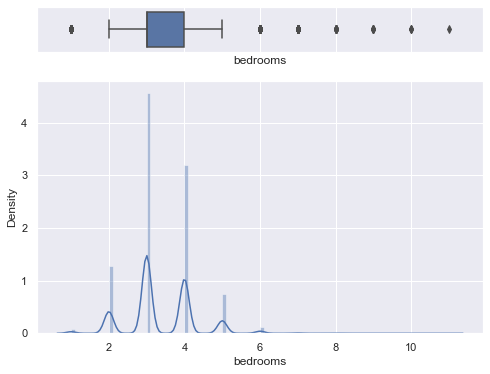

In [16]:
hist_box(df['bedrooms'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- There appears to be a linear relationship between bedrooms and sale price
    - This trend weakens after adding more then 5 bedrooms

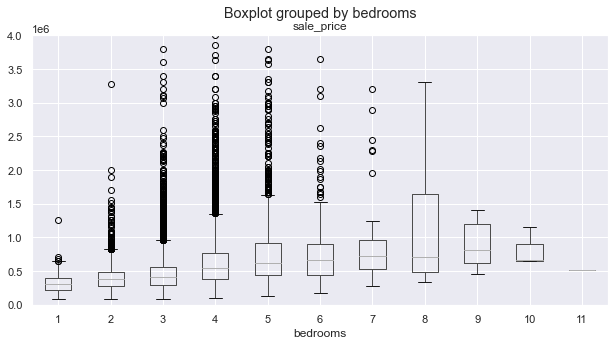

In [17]:
df[['sale_price','bedrooms']].boxplot('sale_price', 
                                      by='bedrooms', 
                                      figsize=(10,5)
                                     ).set_ylim(-10000,4000000);

## 4) Bathrooms: 
- Most houses have between 1 and 3.5 bathrooms

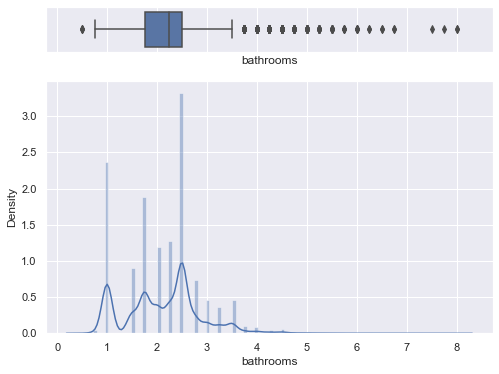

In [18]:
hist_box(df['bathrooms'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- There appears to be a strong relationship between the number of bathrooms and sale price
    - The tightness of the trend weakens at higher bathroom counts due to data density, but still exists

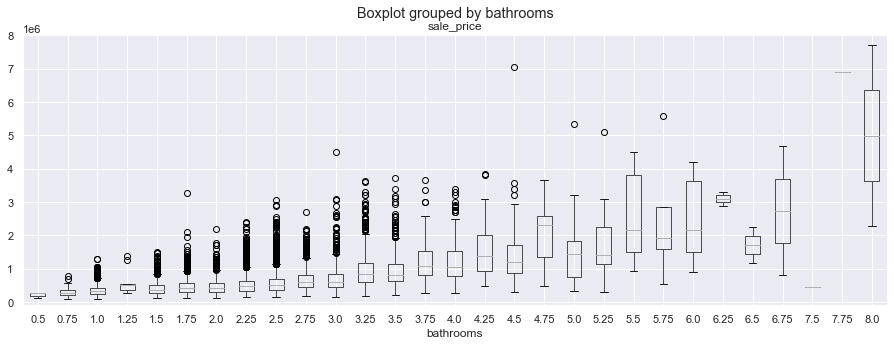

In [19]:
df[['sale_price','bathrooms']].boxplot('sale_price', 
                                      by='bathrooms', 
                                      figsize=(15,5)
                                     ).set_ylim(-100000,8000000);

## 5) Sqft Living: 
- Most houses have less than 4,500 sqft
- Positive Skew
- Likely needs a transform for normality

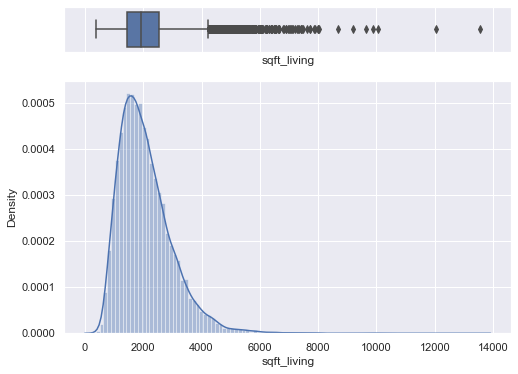

In [20]:
hist_box(df['sqft_living'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- There appears to be a positive relationship between living sqft and sale price


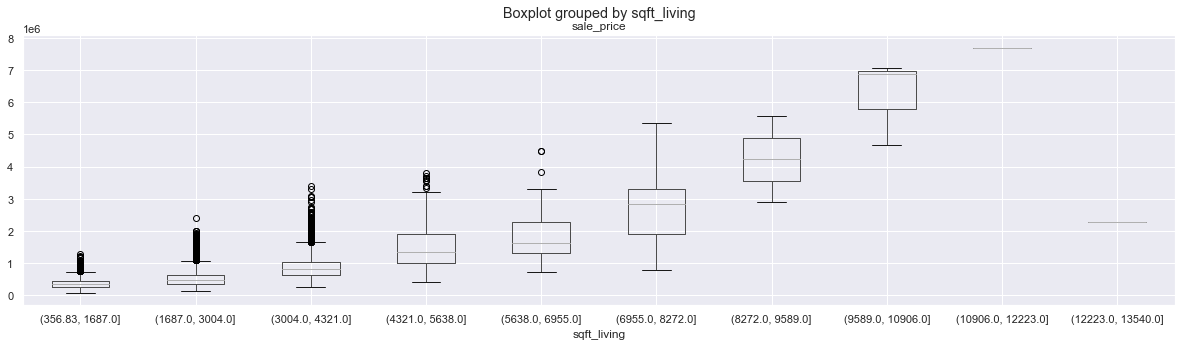

In [21]:
df_temp = df[['sale_price','sqft_living']]
df_temp['sqft_living'] = pd.cut(df['sqft_living'], bins=10)
df_temp[['sale_price','sqft_living']].boxplot('sale_price', 
                                                by='sqft_living', 
                                                figsize=(20,5)
                                                );

## 5) Sqft Lot: 
- Most houses have less thn 25,000 sqft lots, however there are many outliers
- Positive Skew
- Likely needs a transform for normality

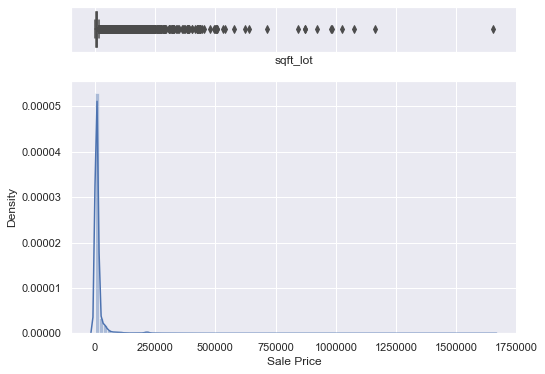

In [22]:
hist_box(df['sqft_lot'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price",
         #x_lim= [-100000,100000]
        )

- This view suggests that we do see a positive relationship as the lot size increases up to about 100,000 sqft

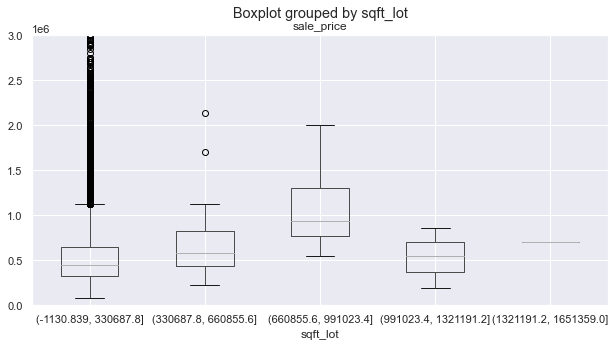

In [23]:
df_temp = df[['sale_price','sqft_lot']]
df_temp['sqft_lot'] = pd.cut(df['sqft_lot'], bins=5)
df_temp[['sale_price','sqft_lot']].boxplot('sale_price', 
                                                by='sqft_lot', 
                                                figsize=(10,5)
                                                ).set_ylim(-1,3000000);

## 6) Floors: 
- Most houses have 1-2 floors

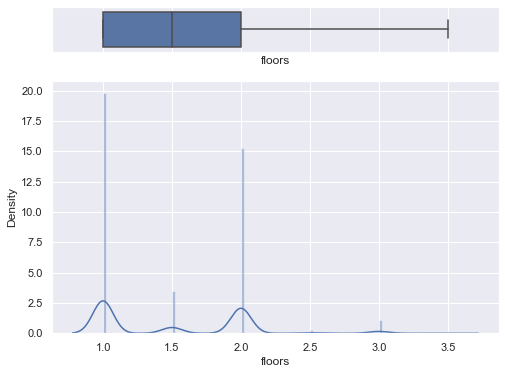

In [24]:
hist_box(df['floors'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="floors",
         #x_lim= [-100000,100000]
        )

- The number of floors has a clear positive relationship with sale price up until 2.5 floors, after which the trend reverses!
    - Quadratic relationship

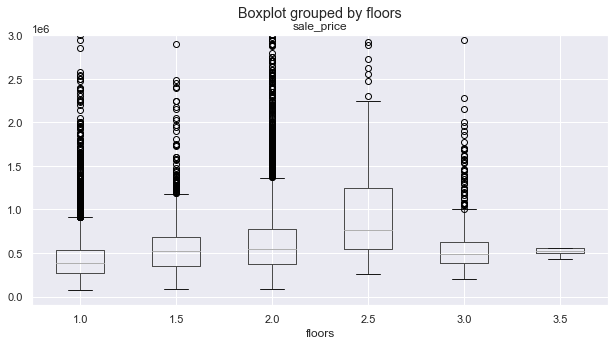

In [25]:
df[['sale_price','floors']].boxplot('sale_price', 
                                      by='floors', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,3000000);

## 7) Waterfront: 
- Most houses are not waterfront

In [26]:
df['waterfront'].value_counts(normalize=True)

0.0000   0.9928
1.0000   0.0072
Name: waterfront, dtype: float64

- Waterfront houses do appear to have a higher sale price!

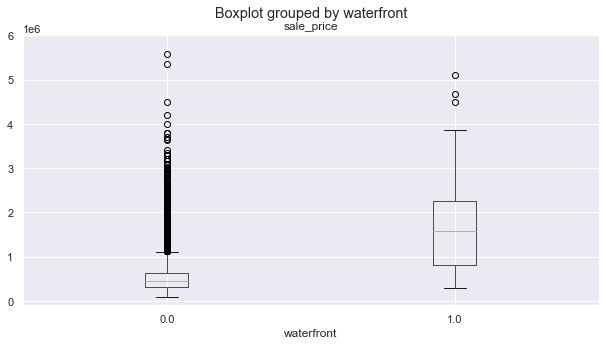

In [27]:
df[['sale_price','waterfront']].boxplot('sale_price', 
                                      by='waterfront', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,6000000);

## 8) Has Been Viewed: 
- Most houses have not been viewed at all

In [28]:
df['has_been_viewed'].value_counts(normalize=True)

0.0000   0.9021
2.0000   0.0441
3.0000   0.0235
1.0000   0.0155
4.0000   0.0148
Name: has_been_viewed, dtype: float64

- Houses that have been viewed more often times have a higher sale price
- Why?
    - This might hint at quality (higher quality houses will get viewed more)
    - This might also hint at demand (houses with multiple offers will sell for more)

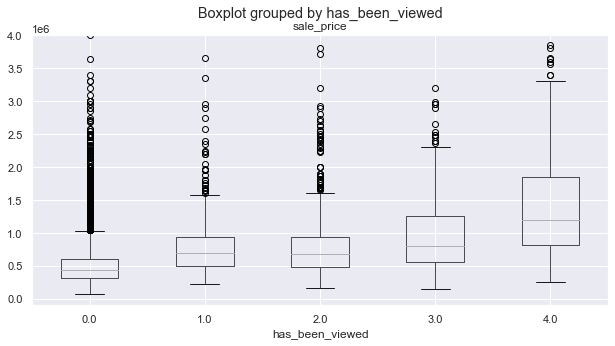

In [29]:
df[['sale_price','has_been_viewed']].boxplot('sale_price', 
                                      by='has_been_viewed', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,4000000);

## 9) Condition: 
- Most houses have a condition rating from 2-5
- Strong negative skew

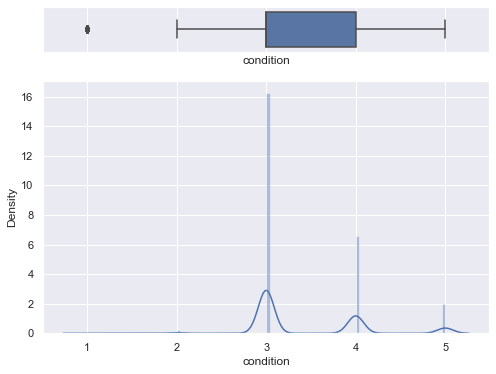

In [30]:
hist_box(df['condition'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- There appears to be a break here at 3, where houses with condition < 3 have a much lower distribution of sale price than those with >= 3

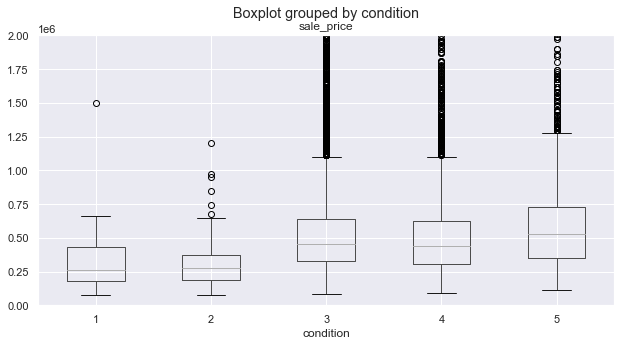

In [31]:
df[['sale_price','condition']].boxplot('sale_price', 
                                      by='condition', 
                                      figsize=(10,5)
                                     ).set_ylim(0,2000000);

## 10) Grade: 
- Most houses have a grade between 6 and 9

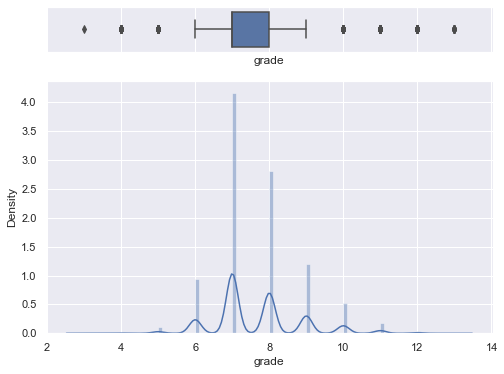

In [32]:
hist_box(df['grade'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         #x_lim= [-100000,100000]
        )

- Grade appears to have a much stronger relationship with sale price than condition did
- It will likely have a much stronger predictive signal that condition

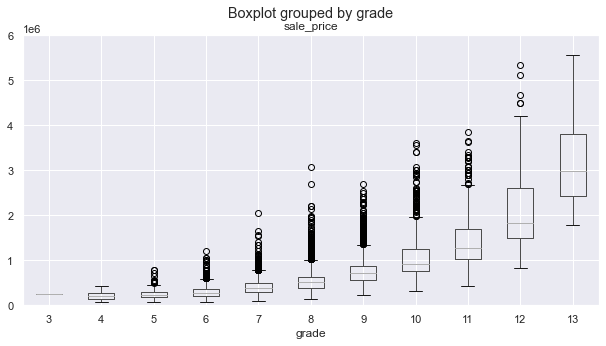

In [33]:
df[['sale_price','grade']].boxplot('sale_price', 
                                      by='grade', 
                                      figsize=(10,5)
                                     ).set_ylim(0,6000000);

## 11) Sqft No Basement: 
- Most houses have less than 4000 sqft excluding their basements
- Positive Skew

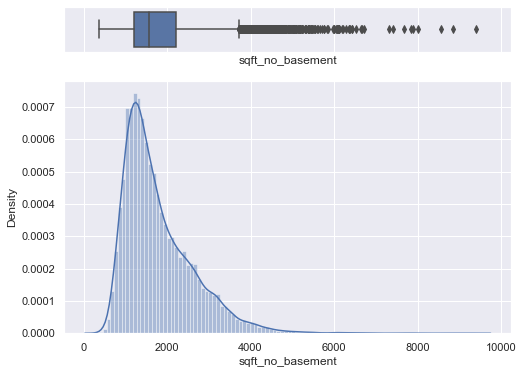

In [34]:
hist_box(df['sqft_no_basement'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Strong relationship between sqft_no_basement and sale price

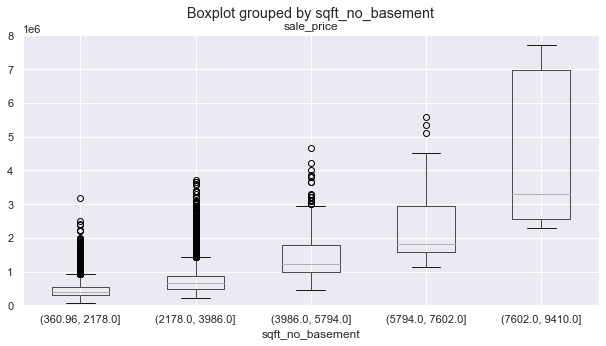

In [35]:
df_temp = df[['sale_price','sqft_no_basement']]
df_temp['sqft_no_basement'] = pd.cut(df['sqft_no_basement'], bins=5)
df_temp[['sale_price','sqft_no_basement']].boxplot('sale_price', 
                                                by='sqft_no_basement', 
                                                figsize=(10,5)
                                                ).set_ylim(-1,8000000);

## 12) Sqft Basement: 
- Most houses don't have a basement

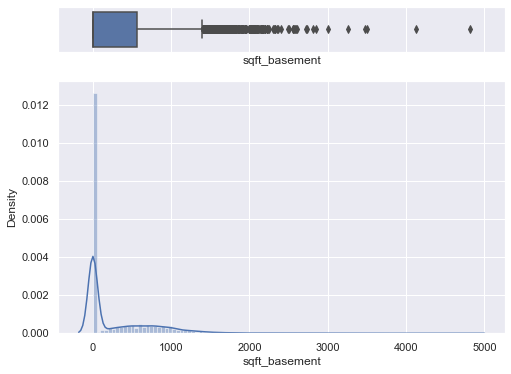

In [36]:
hist_box(df['sqft_basement'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Houses with basements tend to have have higher sale prices

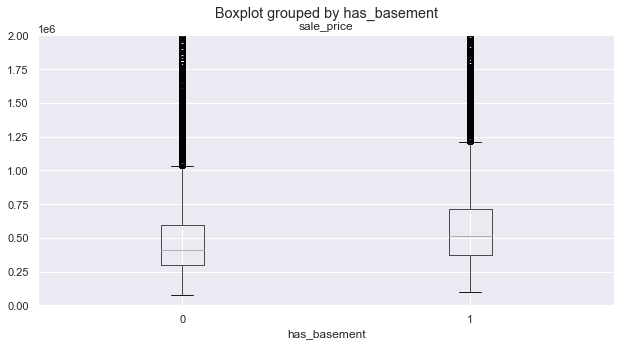

In [37]:
df_temp = df[['sale_price','sqft_basement']]
df_temp['has_basement'] = 0
df_temp.loc[df_temp['sqft_basement'] > 0, 'has_basement'] = 1
df_temp.boxplot('sale_price', 
                by='has_basement', 
                figsize=(10,5)
                ).set_ylim(-1,2000000);

- For houses that have basements, larger basements translate to higher sale prices

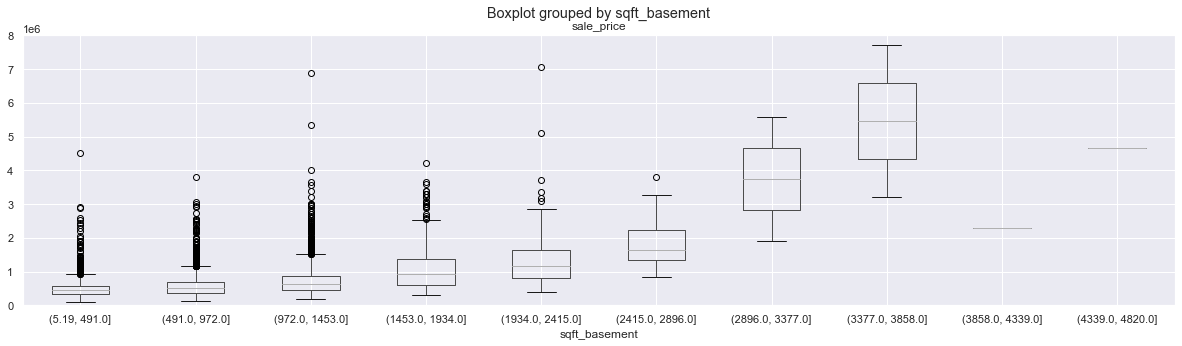

In [38]:
df_temp = df[df['sqft_basement'] > 0][['sale_price','sqft_basement']]
df_temp['sqft_basement'] = pd.cut(df_temp['sqft_basement'], bins=10)
df_temp[['sale_price','sqft_basement']].boxplot('sale_price', 
                                                by='sqft_basement', 
                                                figsize=(20,5)
                                                ).set_ylim(-1,8000000);

## 13) Year Built: 
- Most houses were built between 1960 and 2000

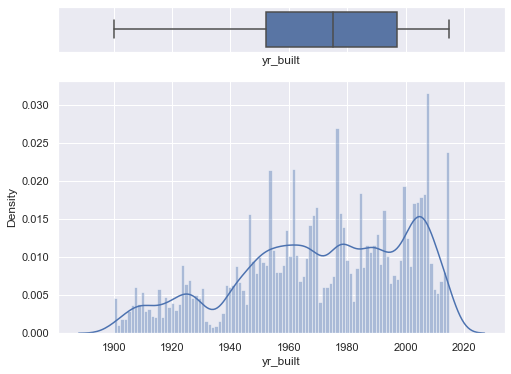

In [39]:
hist_box(df['yr_built'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Interestingly enough, there is not a strong relationship between the year built and the sale price
- Why?
    - The newer houses being built may have other less favorable characteristics (smaller, lower grade)
    - Its also possible that the older homes (< 1920) have been remodelled, reversing the trend

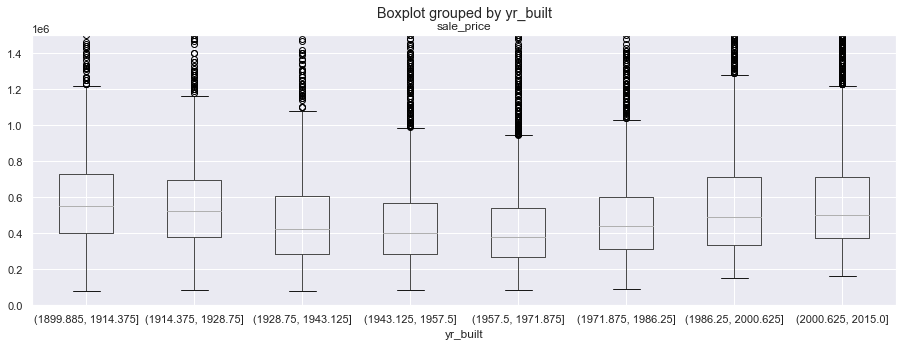

In [40]:
df_temp = df[['sale_price','yr_built']]
df_temp['yr_built'] = pd.cut(df['yr_built'], bins=8)
df_temp[['sale_price','yr_built']].boxplot('sale_price', 
                                            by='yr_built', 
                                            figsize=(15,5)
                                            ).set_ylim(-1,1500000);

## 14) Year Renovated: 
- For homes that were renovated, most were done between 1990 and 2005

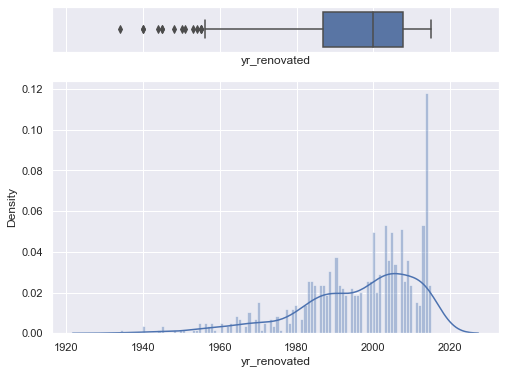

In [41]:
hist_box(df[df['yr_renovated'] > 0]['yr_renovated'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Houses that were renovated tend to have higher sale prices

- For houses that were renovated, those that were worked on more recently tended to have higher sale prices

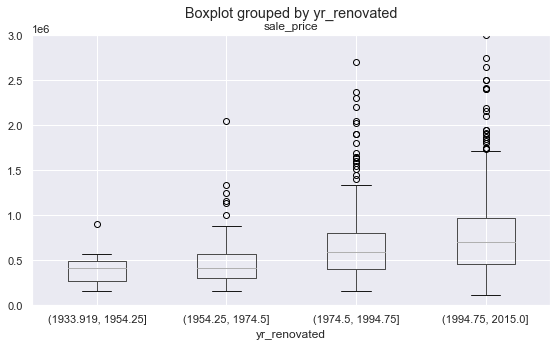

In [42]:
df_temp = df[df['yr_renovated'] > 0][['sale_price','yr_renovated']]
df_temp['yr_renovated'] = pd.cut(df_temp['yr_renovated'], bins=4)
df_temp[['sale_price','yr_renovated']].boxplot('sale_price', 
                                                by='yr_renovated', 
                                                figsize=(9,5)
                                                ).set_ylim(-1,3000000);

- Engineer features "years since last update"
    - For houses with no renovation, its the age of the house
    - For houses with a renovation, its the age of the renovation

In [43]:
df['years_since_update'] = 2022 - df['yr_built']
df.loc[df['yr_renovated'] > 0, 'years_since_update'] = 2022 - df['yr_renovated']

- Interestingly enough, the odd trend seen in year built appears here as well
    - This makes me believe there are confounding variables with houses built a long time ago (location, grade, etc)

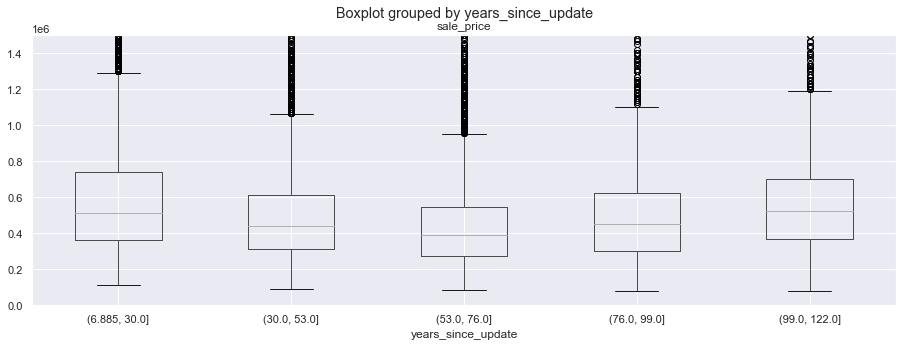

In [44]:
df_temp = df[['sale_price','years_since_update']]
df_temp['years_since_update'] = pd.cut(df_temp['years_since_update'], bins=5)
df_temp[['sale_price','years_since_update']].boxplot('sale_price', 
                                                by='years_since_update', 
                                                figsize=(15,5)
                                                ).set_ylim(-1,1500000);

- Here we see when controlling for grade, the anticipated trend does appear

## 15) Zipcode: 
- For homes that were renovated, most were done between 1990 and 2005

In [45]:
df['zipcode'].nunique()

70

- Get the number of houses and mean sale price within the zipcode
- Sort, then view every ***n*** to see if they differ meaningfully

In [46]:
zip_df = pd.DataFrame()
zip_df['num_houses'] = df.groupby('zipcode')['sale_id'].count()
zip_df['mean_sale_price'] = df.groupby('zipcode')['sale_price'].mean().astype(int)
zip_df = zip_df.sort_values('mean_sale_price', ascending=False)
zip_df.iloc[::7, :]

,num_houses,mean_sale_price
zipcode,,
98039,49,2135612
98119,176,861480
98077,196,681461
98115,565,619752
98024,78,575508
98011,191,490331
98019,188,425467
98038,571,366476
98042,540,311786


- Showing a map view of houses colored by the mean sale price in their zip
- From a map view it becomes very clear that zipcodes contain a lot of information 
    - There almost appears to be tiers of zipcodes

- Note:
    - Feature engineering mean sale price in zipcode must be done ***AFTER*** the test train split, as we are using the dependent variable and want to prevent data leakage

## 16) Lat/Long: 
- Location displays a strong trend with sale price!
    - Areas near Lake Washington and Bellevue have veryhigh prices
    - Towards the south-west end of the map prices are significantly lower

## 17) Sqft Living 15 Nearest Neighbors:
- Another positively skewed distribution

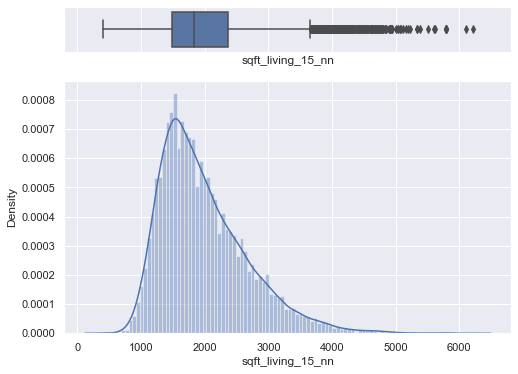

In [47]:
hist_box(df['sqft_living_15_nn'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- There is a strong trend between sale price and the size of nearby houses
- Why?
    - Larger nearby houses might mean a nicer area/neighborhood which tend to sell at a premium

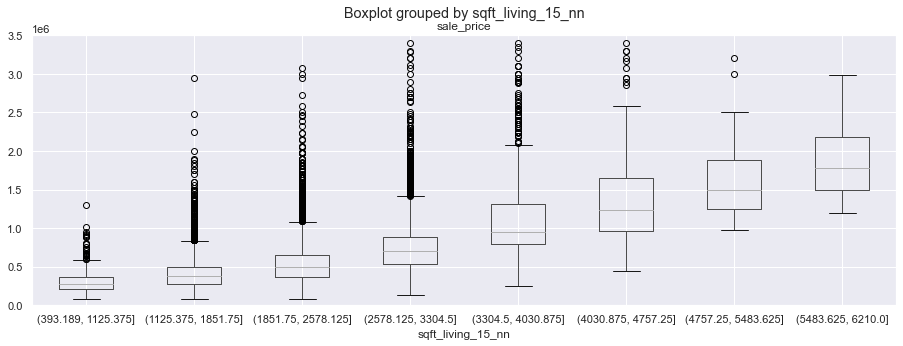

In [48]:
df_temp = df[['sale_price','sqft_living_15_nn']]
df_temp['sqft_living_15_nn'] = pd.cut(df['sqft_living_15_nn'], bins=8)
df_temp[['sale_price','sqft_living_15_nn']].boxplot('sale_price', 
                                                by='sqft_living_15_nn', 
                                                figsize=(15,5)
                                                ).set_ylim(0,3500000);

# Interactions
- Interactions refer to when the relationship between one independent variable and the dependent variable differs across a second independent variable
    - Detecting and accounting for interactions can lead to better models
- As we can see below, the relationsip between sqft_living and sale price is heavily influenced by the grade of the house

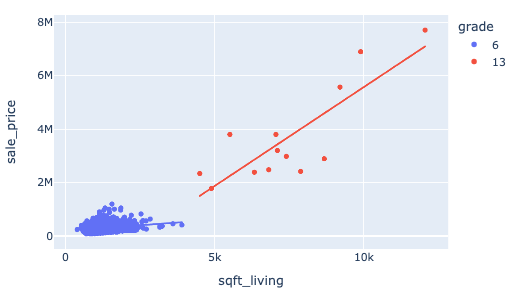

# Declare cleaned DataFrame for EDA

In [81]:
# Drop unwanted columns
df_clean = df.loc[:,~df.columns.str.contains('sale_date|sale_id|yr_built')]
df_clean.sample(5)

,sale_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,has_been_viewed,condition,grade,sqft_no_basement,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living_15_nn,sqft_lot_15_nn,sale_year,sale_month,years_since_update
unique_id,,,,,,,,,,,,,,,,,,,,,
9147,450000.0000,4,2.7500,2900,6400,2.0000,0.0000,0.0000,3,7,2040,860.0000,1970.0000,98136,47.5563,-122.3930,1340,6144,2014,12,52.0000
4229,562000.0000,3,2.0000,3250,50529,2.0000,0.0000,0.0000,4,8,3250,0.0000,0.0000,98075,47.5849,-122.0160,2370,47480,2015,4,44.0000
18033,240000.0000,3,1.0000,1690,20063,1.5000,0.0000,0.0000,4,7,1690,0.0000,0.0000,98001,47.3556,-122.2940,1700,15899,2015,2,109.0000
16204,1490000.0000,3,3.5000,4560,14608,2.0000,0.0000,2.0000,3,12,4560,0.0000,0.0000,98034,47.6995,-122.2280,4050,14226,2015,3,32.0000
10,662500.0000,3,2.5000,3560,9796,1.0000,0.0000,0.0000,3,8,1860,1700.0000,0.0000,98007,47.6007,-122.1450,2210,8925,2015,4,57.0000


##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

In [82]:
df_clean_transformed = df_clean.copy()

for col in ['sale_price','bedrooms','sqft_living','sqft_lot','condition','sqft_living_15_nn','sqft_lot_15_nn']:
        df_clean_transformed[f'{col}_log'] = np.log10(df_clean_transformed[col])

df_clean_transformed = df_clean_transformed.drop(columns=[i for i in df_clean_transformed.columns if str(i) + '_log' in df_clean_transformed.columns])
    
df_clean_transformed.sample(5)

,bathrooms,floors,waterfront,has_been_viewed,grade,sqft_no_basement,sqft_basement,yr_renovated,zipcode,lat,long,sale_year,sale_month,years_since_update,sale_price_log,bedrooms_log,sqft_living_log,sqft_lot_log,condition_log,sqft_living_15_nn_log,sqft_lot_15_nn_log
unique_id,,,,,,,,,,,,,,,,,,,,,
14376,1.7500,1.5000,0.0000,0.0000,6,1950,0.0000,0.0000,98065,47.5232,-121.8210,2014,8,91.0000,5.5250,0.6021,3.2900,4.1284,0.6021,3.1139,3.8711
14057,3.0000,2.0000,0.0000,0.0000,7,1730,500.0000,0.0000,98102,47.6404,-122.3250,2015,4,109.0000,5.9638,0.6990,3.3483,3.6435,0.4771,3.1072,3.2553
12534,1.0000,1.0000,0.0000,0.0000,6,730,0.0000,0.0000,98146,47.4943,-122.3370,2014,10,94.0000,5.0569,0.3010,2.8633,3.7160,0.4771,3.0864,3.7952
16331,2.5000,2.0000,0.0000,0.0000,8,2860,0.0000,0.0000,98065,47.5265,-121.8350,2014,7,64.0000,5.8261,0.6990,3.4564,4.8358,0.6990,3.2227,4.5552
16602,2.2500,2.0000,0.0000,0.0000,7,2060,0.0000,0.0000,98077,47.7440,-122.0460,2015,3,34.0000,5.6990,0.6021,3.3139,4.6477,0.4771,3.3345,4.6595


### Feature Engineer with Target Variable:
- Logic:
    - Split data into test and train sets
    - Calculate feature using only the training data
    - Add features to X_train and X_test

In [83]:
def split_and_engineer_w_target(cleaned_dataframe,rand_state = 8):
    '''
    Accepts dataframe
    Returns test and train splits with features engineered using target variable given the random state
    '''
    
    # Define independent and dependent variables
    X = df_clean.drop(columns='sale_price')
    y = df_clean['sale_price']

    # Perform first test/train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rand_state) 

    # Get all train data together
    train_data = df_clean.loc[X_train.index,:]

    # Feature engineer
    train_zip_df = pd.DataFrame()
    train_zip_df['num_houses'] = train_data.groupby('zipcode')['zipcode'].count()
    for col in ['sale_price','sqft_living','grade','years_since_update','sqft_lot','condition','bedrooms']:
        train_zip_df[f'mean_{col}'] = train_data.groupby('zipcode')[col].mean()

    for col in train_zip_df.columns:
        X_train[f'{col}_in_zip'] = X_train['zipcode'].map(train_zip_df[col].to_dict())    
        X_test[f'{col}_in_zip'] = X_test['zipcode'].map(train_zip_df[col].to_dict())
    
    X_train = X_train.drop(columns='zipcode')
    X_test = X_test.drop(columns='zipcode')

    return X_train, X_test, y_train, y_test

In [162]:
X_train, X_test, y_train, y_test = split_and_engineer_w_target(df_clean, 8)

### Interactions

In [163]:
cols_to_include = X_train.columns

for i1, col1 in enumerate(cols_to_include):
    for col2 in cols_to_include[i1+1:]:
        X_train[f'{col1}_x_{col2}'] = X_train[col1] * X_train[col2]
        X_test[f'{col1}_x_{col2}'] = X_test[col1] * X_test[col2]

### View Correlations

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Modelling:
- While exploring the data, several items were uncovered relevant to model selection:
    - Non-Linear Relationships
    - Non-Normal Distributions
    - Interactions
- While the non-normal distributions and interactions may be accounted for with transformations, the non-linear relationships within the data lead me away from a linear regression model
    - Normally to account for interactions we need to create new features via combinations of the old, and this does impact model explainability (especially to those unfamiliar with the data)
- A tree based approach can account for all of the items mentioned above with no transformations, and maintains relatively high interpretability

# 1) Linear Regression:

In [164]:
lr = linear_model.Lasso(alpha=100000)
lr.fit(X_train, y_train)

Lasso(alpha=100000)

In [165]:
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f'Train Score: {round(train_score,3)} \nTest Score: {round(test_score,3)}')

Train Score: 0.897 
Test Score: 0.893


In [166]:
tt = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))
tt = tt[tt['coef'] > 20]

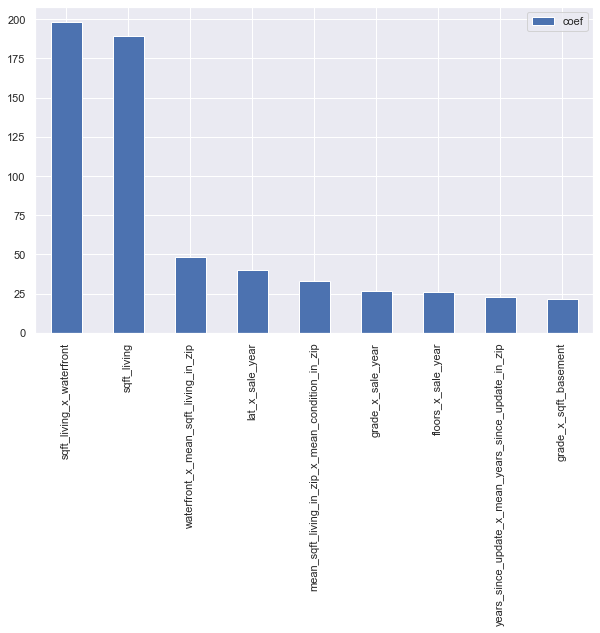

In [167]:
tt.plot.bar(figsize=(10,6));

### Explore Interesting Interactions

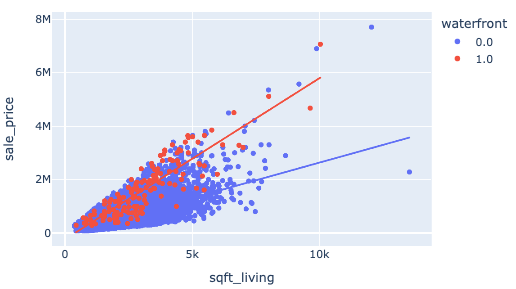

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

### Re-create "best" model calculate predictions, actuals, residuals

In [ ]:
df_clean_clip = df_cleaned[df_cleaned['sqft_lot'] < 350000]
df_clean_clip_engineered, X_train0, X_test0, y_train0, y_test0 = feature_engineer(df_clean_clip, 1)
df_temp = log_transform_and_drop(df_clean_clip_engineered)
R2, adj_r2, results_dict, model = split_and_model(df_temp,X_train0, X_test0, y_train0, y_test0)
X = df_temp.drop(columns=['sale_price_log'])
y = df_temp['sale_price_log']
comparison_df = X.copy()
comparison_df['Prediction'] = model.predict(comparison_df)
comparison_df['Actual'] = y
comparison_df['Residual'] = comparison_df['Prediction'] - comparison_df['Actual']

### Plot predictions vs actuals

In [ ]:
fig = px.scatter(comparison_df, 
                 x='Prediction', 
                 y='Actual', 
                 trendline="ols",
                 color='Residual',
                 color_continuous_scale='portland',
                 title='Model Prediction Price vs Actual Price',
                 height = 400,
                 width = 700
                )
fig.show()

### Identify undervalued homes after visual inspection

In [ ]:
df_opportunity = comparison_df[comparison_df['Residual'] > 0.20]
display(df_opportunity.shape)
df_opportunity.head()

### Map Residuals

In [ ]:
import folium
import branca.colormap as cm

# Create map
map_visual = folium.Map(location=(df_opportunity['lat'].mean(), df_opportunity['long'].mean()), zoom_star = 9, width = 500, height = 500)

# Specify feature to color by
color_by = 'Residual'

# Create color map
colormap = cm.LinearColormap(colors=['black','gray','green','yellow','orange','red'], vmin=.15, vmax= .4)

# Loop through each home in set, create circle, add to map.
for idx in df_opportunity.index:
    folium.Circle(
        location=[df_opportunity.loc[idx]['lat'], df_opportunity.loc[idx]['long']],
        radius = 100,
        fill=True,
        color = colormap(df_opportunity.loc[idx][color_by]),
    
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Sale Price'
map_visual.add_child(colormap)

# View
map_visual